In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [8]:
data = pd.read_csv('C:\\Users\\raibe\\Desktop\\Thesis Code\\datasets\\data batches\\ndb1.csv')

In [9]:
data = data.drop(["label", "default", "current_year"], axis=1)

In [10]:
data.head()

,time,payoff,int.rate,orig.upb,fico.score,dti.r,ltv.r,bal.repaid,t.act.12m,t.del.30d.12m,...,ppi.o.FRMA,equity.est,hpi.st.log12m,hpi.r.st.us,hpi.r.zip.st,st.unemp.r12m,st.unemp.r3m,TB10Y.r12m,T10Y3MM,T10Y3MM.r12m
0,20,1,7.00,63000,657,26,79,2.078556,11,1,...,1.01,32293.92,0.146144,1.110008,1.234804,-0.7,-0.1,0.39,3.41,0.58
1,7,1,7.00,132000,647,33,80,0.583939,11,1,...,-0.18,46221.55,0.146154,1.078726,1.668582,0.9,0.1,-0.86,2.24,0.15
2,9,1,6.25,152000,761,29,80,0.871974,12,0,...,0.32,42039.07,0.093969,1.054944,1.006483,0.6,0.0,0.19,3.50,0.86
3,31,1,7.00,50000,758,24,37,3.386060,12,0,...,-0.23,106211.90,0.033797,0.968266,1.407201,2.1,0.9,-1.07,2.78,3.23
4,18,1,6.75,181000,653,29,55,1.415833,11,1,...,-0.06,163735.70,0.017066,0.893576,1.507073,0.5,0.0,-0.67,3.08,0.11


In [ ]:
data.columns

In [6]:
df_train = data
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [7]:
cols_standardize = ['int.rate', 'orig.upb', 'fico.score', 'dti.r',
       'ltv.r', 'bal.repaid','hpi.st.d.t.o', 'hpi.zip.o', 'hpi.zip.d.t.o', 'ppi.c.FRMA',
       'TB10Y.d.t.o', 'FRMA30Y.d.t.o', 'ppi.o.FRMA', 'equity.est',
       'hpi.st.log12m', 'hpi.r.st.us', 'hpi.r.zip.st', 'st.unemp.r12m',
       'st.unemp.r3m', 'TB10Y.r12m', 'T10Y3MM', 'T10Y3MM.r12m']
       
cols_leave = ['t.act.12m', 't.del.30d.12m', 't.del.60d.12m']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [8]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [9]:
labtrans = CoxTime.label_transform()
get_target = lambda df: (df['time'].values, df['payoff'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)

C:\Users\raibe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass copy=True, with_mean=True, with_std=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [ ]:
val.shapes()

In [ ]:
val.repeat(2).cat().shapes()

In [10]:
in_features = x_train.shape[1]
num_nodes = [256, 256, 256, 256]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

In [11]:
model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)

C:\Users\raibe\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


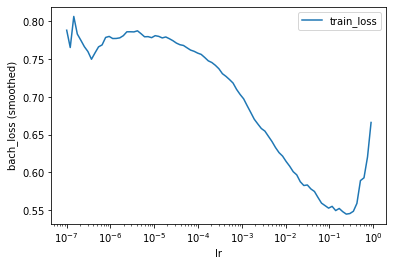

In [12]:
batch_size = 128
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [ ]:
lrfinder.get_best_lr()

In [13]:
model.optimizer.set_lr(0.001)

In [14]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [15]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

0:	[1s / 1s],		train_loss: 0.4141,	val_loss: 0.3578
1:	[2s / 4s],		train_loss: 0.3023,	val_loss: 0.3340
2:	[2s / 7s],		train_loss: 0.2659,	val_loss: 0.3128
3:	[2s / 10s],		train_loss: 0.2758,	val_loss: 0.3019
4:	[2s / 12s],		train_loss: 0.2543,	val_loss: 0.2727
5:	[2s / 14s],		train_loss: 0.2451,	val_loss: 0.2632
6:	[2s / 16s],		train_loss: 0.2471,	val_loss: 0.2478
7:	[2s / 19s],		train_loss: 0.2361,	val_loss: 0.2833
8:	[2s / 21s],		train_loss: 0.2398,	val_loss: 0.2472
9:	[1s / 23s],		train_loss: 0.2270,	val_loss: 0.2352
10:	[2s / 25s],		train_loss: 0.2282,	val_loss: 0.2427
11:	[1s / 27s],		train_loss: 0.2285,	val_loss: 0.2823
12:	[2s / 29s],		train_loss: 0.2258,	val_loss: 0.2274
13:	[3s / 32s],		train_loss: 0.2112,	val_loss: 0.2253
14:	[3s / 35s],		train_loss: 0.2110,	val_loss: 0.2151
15:	[3s / 38s],		train_loss: 0.2076,	val_loss: 0.2019
16:	[1s / 40s],		train_loss: 0.1998,	val_loss: 0.2086
17:	[2s / 43s],		train_loss: 0.2046,	val_loss: 0.2104
18:	[2s / 45s],		train_loss: 0.1937,	val_

In [ ]:
_ = log.plot()

In [ ]:
model.partial_log_likelihood(*val).mean()

In [ ]:
_ = model.compute_baseline_hazards()

In [ ]:
surv = model.predict_surv_df(x_test)

In [ ]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td()

In [ ]:
from lifelines.utils import concordance_index

In [ ]:
print(concordance_index(event_times=durations_test, predicted_scores=surv.loc[72,], event_observed=events_test))

In [ ]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 60)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

In [ ]:
ev.integrated_brier_score(time_grid) 